In [2]:
import sys
sys.path.insert(0, './..')
sys.path.insert(0, '../data')

import matplotlib.pyplot as plt
import numpy as np
import plots as pl
from models import model
import torch
from utils import dev, load_data, classification
from torchvision import datasets, transforms
from models import eval
from matplotlib.ticker import FormatStrFormatter


# Load models

In [3]:
# load models
model_natural = model.madry_diff()
model_robust = model.madry_diff()
model_natural.load_state_dict(torch.load('../models/natural_0.pt', map_location=torch.device(dev())))
model_robust.load_state_dict(torch.load('../models/robust_0.pt', map_location=torch.device(dev())))
model_natural.to(dev())
model_robust.to(dev())
model_natural.eval()
model_robust.eval()

madry_diff(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (elu): ELU(alpha=1.0)
)

# Check seed consistency

2.168138000691178

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

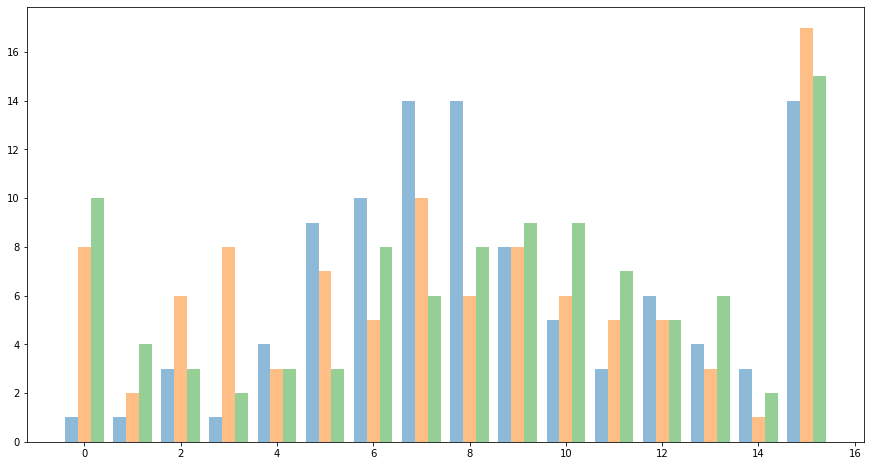

In [20]:
data = np.load('../data/natural0.npy', allow_pickle=True).item()
images = data['images']
labels = data['labels']
n_advs = np.zeros((3,len(images)))
for i,model_id in enumerate([0,1,2]):
    # load data
    data = np.load('../data/natural'+str(model_id)+'.npy', allow_pickle=True).item()
    advs = data['advs']
    pert_lengths = data['pert_lengths']
    classes = data['adv_class']
    dirs = data['dirs']
    images = data['images']
    labels = data['labels']
    pert_lengths = data['pert_lengths']
    n_advs[i] = 15-np.isnan(pert_lengths).sum(1)
plt.figure(figsize=(15,8))
plt.hist(n_advs.T, alpha=0.5, bins=16, range=(-0.5,15.5))
np.mean(np.std(n_advs,axis=0))

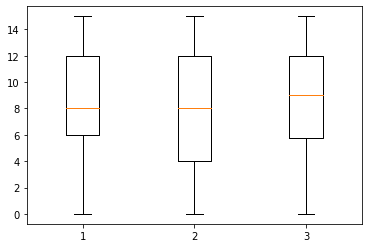

In [400]:
fig, ax = plt.subplots()
ax.boxplot(n_advs.T)
plt.show()

# Load data

In [3]:
# load data
data = np.load('../data/natural_0.npy', allow_pickle=True).item()
advs = data['advs']
pert_lengths = data['pert_lengths']
classes = data['adv_class']
dirs = data['dirs']
images = data['images']
labels = data['labels']
pert_lengths = data['pert_lengths']

data = np.load('../data/robust_0.npy', allow_pickle=True).item()
advs_madry = data['advs']
pert_lengths_madry = data['pert_lengths']
classes_madry = data['adv_class']
dirs_madry = data['dirs']
images_madry = data['images']
labels_madry = data['labels']

# Plot grid of adversarial examples

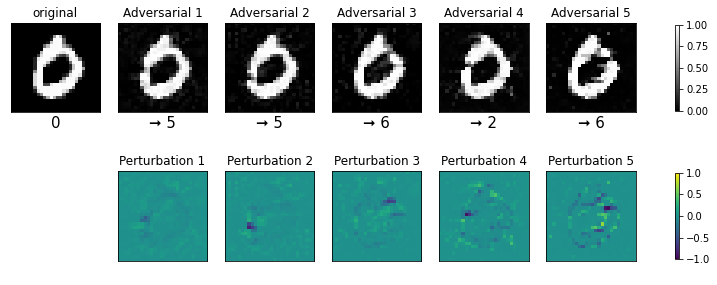

In [150]:
img_n = 0
fig , ax = pl.plot_advs(advs[img_n], orig=images[img_n], classes=classes[img_n], orig_class=labels[img_n], n=5,vmin=0,vmax=1)
fig.set_figheight(5)
fig.set_figwidth(14)


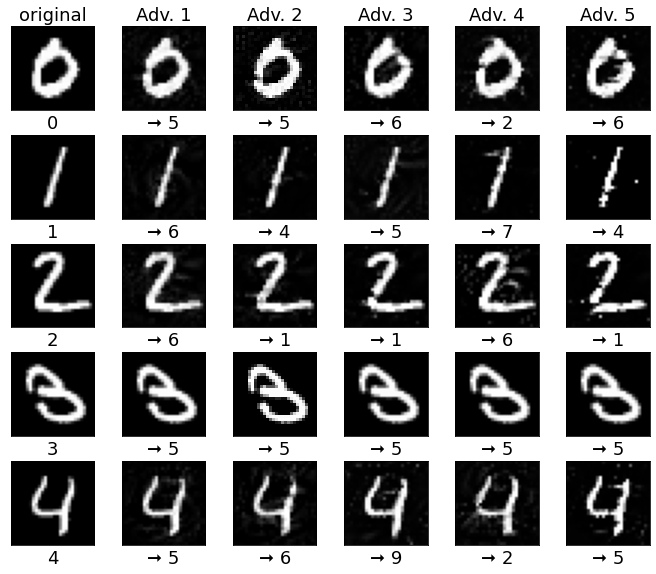

In [5]:
fig, ax = plt.subplots(5, 6, squeeze=False, figsize=(9,8))
for j in range(5):
    orig = np.reshape(images[j*50], [28, 28])
    if j == 0:
        ax[j, 0].set_title('original', fontsize=18)
    ax[j, 0].imshow(orig, cmap='gray', vmin=0, vmax=1)
    ax[j, 0].set_xticks([])
    ax[j, 0].set_yticks([])
    ax[j, 0].set_xlabel(str(labels[j*50]), fontdict={'fontsize': 18})

    for i, a in enumerate(advs[j*50,:5]):
        if j==0:
            ax[j, i+1].set_title('Adv. ' + str(i + 1), fontsize=18)
        ax[j, i+1].set_xlabel('\u279E ' + str(int(classes[j*50,i])), fontdict={'fontsize': 18})
        ax[j, i+1].imshow(a.reshape([28, 28]), cmap='gray', vmin=0, vmax=1)
        ax[j, i+1].set_xticks([])
        ax[j, i+1].set_yticks([])
plt.subplots_adjust(hspace=0.3, left=0, right=1, bottom=0.05, top=0.95)
plt.show()

# Plot madry and natural adversarial examples in one figure

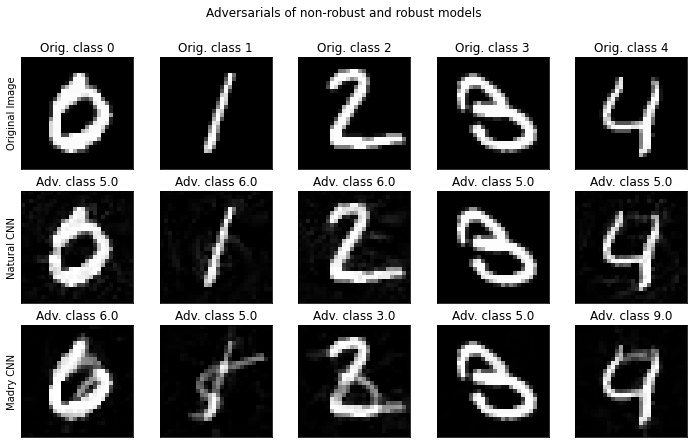

In [8]:
plt.figure(figsize=(12,7))
for i in range(5):
    plt.subplot(3,5,1+i)
    plt.title('Orig. class ' + str(labels[i*50]))
    plt.imshow(np.reshape(images[i*50], [28,28]), cmap='gray', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel("Original Image")
    
    plt.subplot(3,5,6+i)
    plt.title('Adv. class ' + str(classes[i*50,0]))
    plt.imshow(np.reshape(advs[i*50,0], [28,28]), cmap='gray', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel("Natural CNN")

    plt.subplot(3,5,11+i)
    plt.title('Adv. class ' + str(classes_madry[i*50,0]))
    plt.imshow(np.reshape(advs_madry[i*50,0], [28,28]), cmap='gray', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel("Madry CNN")
plt.suptitle('Adversarials of non-robust and robust models')
plt.show()

# Perturbation Length comparison

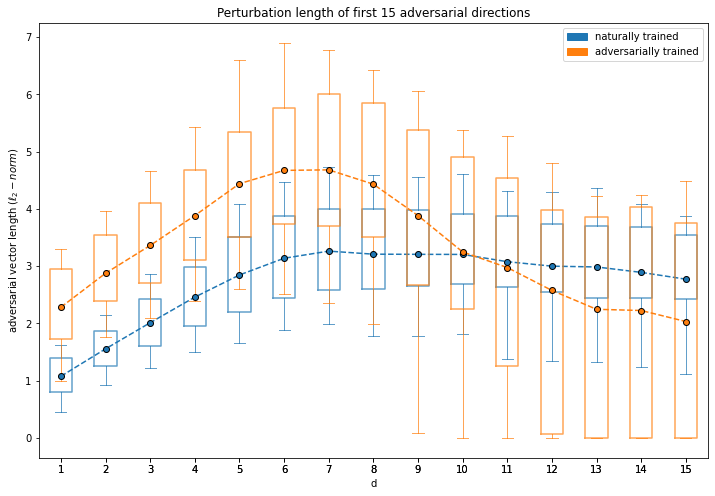

In [23]:
# plot with all adversarials included
fig , ax = pl.plot_pert_lengths([pert_lengths,pert_lengths_madry],  n=15, labels=['naturally trained','adversarially trained'], ord=2)
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()


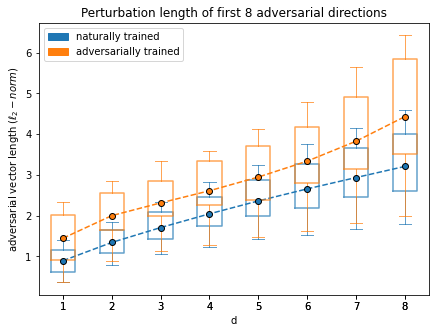

In [11]:
# only samples with at least n adversarials included
n=8

p_robust = pert_lengths_madry[np.invert(np.isnan(pert_lengths_madry)).sum(-1)>=n]
p_natural = pert_lengths[np.invert(np.isnan(pert_lengths)).sum(-1)>=n]
        
fig , ax = pl.plot_pert_lengths([p_natural,p_robust],  n=n, labels=['naturally trained','adversarially trained'], ord=2)
fig.set_figheight(5)
fig.set_figwidth(7)
plt.show()

# Plot variation of target classes

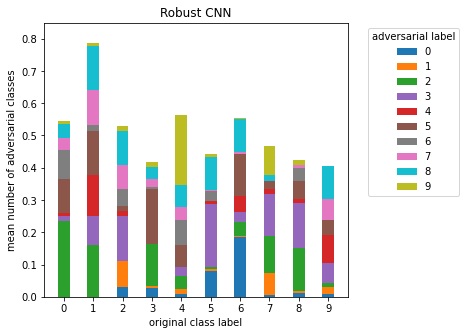

In [16]:
classes_ = classes_madry
pert_lengths_ = pert_lengths_madry

mask_idx = np.invert(np.isnan(pert_lengths)).sum(1)>1
classes_[np.isnan(pert_lengths_)]=np.nan
classes_ = classes_[mask_idx]
labels_ = labels[mask_idx]
fig, ax = pl.plot_var_hist(classes_, labels_, title='Robust CNN', with_colors = True)
fig.set_figheight(5)
fig.set_figwidth(7)
plt.ylim(0,.85)
plt.show()

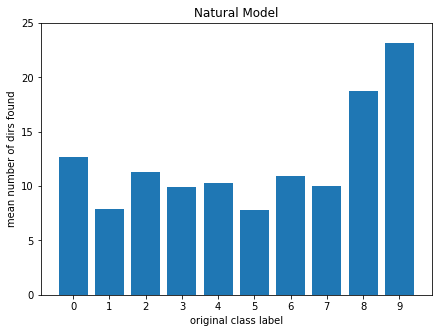

In [21]:
advs_per_class = np.zeros(10)
for l in range(10):
    p = pert_lengths[labels==l]
    advs_per_class[l] = np.mean(np.invert(np.isnan(p)).sum(1))
plt.figure(figsize=(7,5))
plt.bar(range(10),advs_per_class)
plt.xticks(np.arange(0,10))
plt.xlabel('original class label')
plt.ylabel('mean number of dirs found')
plt.title('Natural Model')
plt.ylim(0,25)
plt.show()
# print(np.mean(advs_per_class),np.mean(np.invert(np.isnan(pert_lengths)).sum(1)))


# Distance to decision boundary

In [47]:
def get_dist_dec(orig, label, dirs, model, n_samples=1000):
# orig=images[1]
# dirs=dirs[1,:2]
# model = model_natural
    n_scales = 100
    n_dirs = len(dirs)
    dirs=dirs.reshape((n_dirs,-1))

    scales = np.linspace(0,10,n_scales)

    coeffs = abs(np.random.normal(size=[n_samples, n_dirs]))
    samples = (coeffs@dirs)
    samples = samples/np.linalg.norm(samples, axis=-1, keepdims=True)
    dists = np.zeros(n_samples)

    for i, sample in enumerate(samples):
        input_dirs = np.outer(scales,sample)
        input = (input_dirs + orig.reshape((-1,784)))
        pred = model(torch.tensor(input.reshape(-1,1,28,28), device=dev())).detach().cpu().numpy()
        pred_classes = np.argmax(pred, axis=-1)
        

        if np.all(pred_classes == label):
            dists[i] = np.nan
        else:
            idx = np.min(np.argwhere(pred_classes != label))

            new_scales = np.linspace(scales[idx-1],scales[idx],n_scales)
            input_dirs = np.outer(new_scales,sample).reshape((-1,1,28,28))
            input = (input_dirs + orig.reshape((-1,1,28,28)))
            pred = model(torch.tensor(input, device=dev())).detach().cpu().numpy()
            pred_classes = np.argmax(pred, axis=-1)
            idx = np.min(np.argwhere(pred_classes != label))
            
            if input[idx].max()>1 or input[idx].min()<0:
                dists[i] = np.nan
            else:
                dists[i] = np.linalg.norm(input_dirs[idx])

    return dists

In [48]:
n_samples = 100
images_ = images[np.invert(np.isnan(pert_lengths)).sum(-1)>8]
labels_ = labels[np.invert(np.isnan(pert_lengths)).sum(-1)>8]
dirs_ = dirs[np.invert(np.isnan(pert_lengths)).sum(-1)>8]
dists = np.zeros((len(images_),8,n_samples))

for i, img in enumerate(images_):
    for n in np.arange(1,9):
        dists[i, n-1] = get_dist_dec(img, labels_[i], dirs_[i,:n], model_natural, n_samples=n_samples)
    

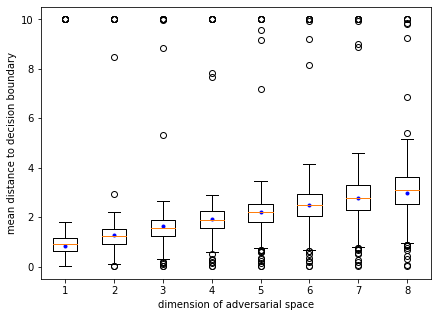

In [49]:
fig, ax = plt.subplots(figsize=(7,5))
mean_dists = np.nanmean(dists,axis=-1)
mask = ~np.isnan(mean_dists)
filtered_data = [d[m] for d, m in zip(mean_dists.T, mask.T)]
ax.boxplot(filtered_data)
ax.plot(np.arange(1,9),np.nanmean(pert_lengths[np.invert(np.isnan(pert_lengths)).sum(-1)>8,:8], axis=0),'b.')
plt.xlabel('dimension of adversarial space')
plt.ylabel('mean distance to decision boundary')
plt.show()
# dists

Text(0, 0.5, 'rate of out of bounds samples')

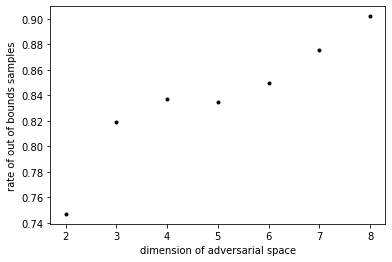

In [45]:
plt.plot(np.arange(2,9),np.mean(np.isnan(dists).sum(-1),axis=0)[1:]/n_samples,'k.')
plt.xlabel('dimension of adversarial space')
plt.ylabel('rate of out of bounds samples')

# Decision Space Visualization

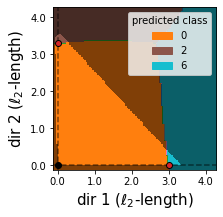

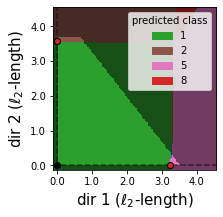

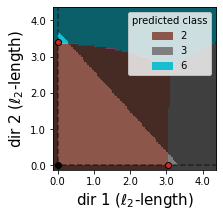

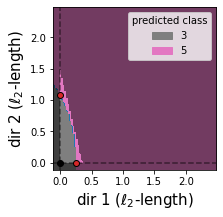

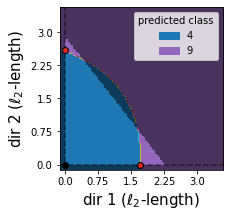

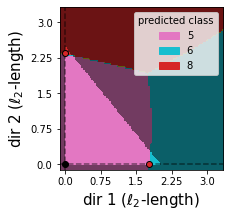

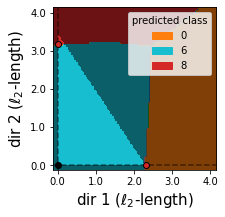

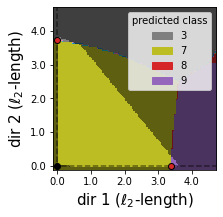

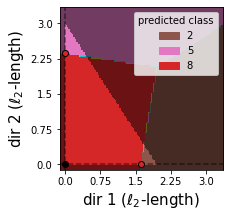

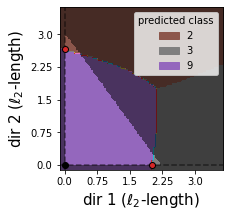

In [18]:
for img_n in [0,50,100,150,200,250,300,350,400,450]:
    orig = images[img_n]
    adv1 = advs_madry[img_n,0]
    adv2 = advs_madry[img_n,1]
    model_ = model_robust
    pl.plot_dec_space(orig, adv1, adv2, model_, show_legend=True, show_advs=True, overlay_inbounds=True)
    plt.rcParams["figure.figsize"] = (20,3)
    plt.show()